# Prompt Engineering on SageMaker Jumpstart

---
In this notebook we will use Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)to try out the various Prompt Engineering Techniques specified here [Prompt Engineering on SageMaker](https://www.promptingguide.ai/).


In this demo notebook, we demonstrate how to use the SageMaker Python SDK for deploying Foundation Models as an endpoint and subsequently use them to test the Prompts we curate. The Foundation models perform **Text2Text Generation**. It takes a prompting text as an input, and returns the text generated by the model according to the prompt.

Here, we show how to use the state-of-the-art pre-trained **FLAN T5 models** from [Hugging Face](https://huggingface.co/docs/transformers/model_doc/flan-t5) for Text2Text Generation in the following tasks. You can directly use FLAN-T5 model for many NLP tasks, without fine-tuning the model.



---

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

### 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires ipywidgets.

---

In [2]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker --quiet

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they re

#### Permissions and environment variables

---
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

---

In [19]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### 2. Select a pre-trained model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [SageMaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [20]:
model_id, model_version = "huggingface-text2text-flan-t5-xl", "*"

***
[Optional] Select a different SageMaker pre-trained model. Here, we download the model_manifest file from the Built-In Algorithms s3 bucket, filter-out all the Text Generation models and select a model for inference.
***

In [21]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text Generation models available by SageMaker Built-In Algorithms.
filter_value = "task == text2text"
text_generation_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=text_generation_models,
    value=model_id,
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

#### Choose a model for Inference

In [22]:
display(model_dropdown)

A Jupyter Widget

In [23]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "1.*"

### 3. Retrieve Artifacts & Deploy an Endpoint

***

Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.

***

In [24]:
def get_sagemaker_session(local_download_dir) -> sagemaker.Session:
    """Return the SageMaker session."""

    sagemaker_client = boto3.client(
        service_name="sagemaker", region_name=boto3.Session().region_name
    )

    session_settings = sagemaker.session_settings.SessionSettings(
        local_download_dir=local_download_dir
    )

    # the unit test will ensure you do not commit this change
    session = sagemaker.session.Session(
        sagemaker_client=sagemaker_client, settings=session_settings
    )

    return session

We need to create a directory to host the downloaded model. 

In [25]:
!mkdir -p download_dir

---
This text-to-text generation task supports a wide variety of model sizes that have different compute requirements. Here, we specify the instance type for several large models along with an environment variable to set the multi-model endpoint number of workers to 1. This ensures we can support the largest possible token lengths since additional models are not consuming GPU memory resources.

---

In [26]:
_large_model_env = {
    "SAGEMAKER_MODEL_SERVER_WORKERS": "1",
    "TS_DEFAULT_WORKERS_PER_MODEL": "1"
}
_model_env_variable_map = {
    "huggingface-text2text-flan-t5-xxl": _large_model_env,
    "huggingface-text2text-flan-t5-xxl-fp16": _large_model_env,
    "huggingface-text2text-flan-t5-xxl-bnb-int8": _large_model_env,
    "huggingface-text2text-flan-t5-xl": {"MMS_DEFAULT_WORKERS_PER_MODEL": "1"},
    "huggingface-text2text-flan-t5-large": {"MMS_DEFAULT_WORKERS_PER_MODEL": "1"},
    "huggingface-text2text-flan-ul2-bf16": _large_model_env,
    "huggingface-text2text-bigscience-t0pp": _large_model_env,
    "huggingface-text2text-bigscience-t0pp-fp16": _large_model_env,
    "huggingface-text2text-bigscience-t0pp-bnb-int8": _large_model_env,
}

In [27]:
from sagemaker import image_uris, instance_types, model_uris, script_uris
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# Retrieve the inference instance type for the specified model.
instance_type = instance_types.retrieve_default(
    model_id=model_id, model_version=model_version, scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

# Retrieve the model uri.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# Create the SageMaker model instance
if model_id in _model_env_variable_map:
    # For those large models, we already repack the inference script and model
    # artifacts for you, so the `source_dir` argument to Model is not required.
    model = Model(
        image_uri=deploy_image_uri,
        model_data=model_uri,
        role=aws_role,
        predictor_cls=Predictor,
        name=endpoint_name,
        env=_model_env_variable_map[model_id],
    )
else:
    model = Model(
        image_uri=deploy_image_uri,
        source_dir=deploy_source_uri,
        model_data=model_uri,
        entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
        role=aws_role,
        predictor_cls=Predictor,
        name=endpoint_name,
        sagemaker_session=get_sagemaker_session("download_dir"),
    )

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
---------!

### 4. Query endpoint and parse response

---
Input to the endpoint is any string of text formatted as json and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

---

In [28]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"


def query_endpoint(encoded_text, endpoint_name):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType="application/x-text", Body=encoded_text
    )
    return response


def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    generated_text = model_predictions["generated_text"]
    return generated_text

---
Below, we put in some example input text. You can put in any text and the model predicts next words in the sequence. Longer sequences of text can be generated by calling the model repeatedly.

---

In [33]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

text1 = "Translate to German:  My name is Arthur"
text2 = "A step by step recipe to make bolognese pasta:"


for text in [text1, text2]:
    query_response = query_endpoint(text.encode("utf-8"), endpoint_name=endpoint_name)
    generated_text = parse_response(query_response)
    print(
        f"Inference:{newline}"
        f"input text: {text}{newline}"
        f"generated text: {bold}{generated_text}{unbold}{newline}"
    )

Inference:
input text: Translate to German:  My name is Arthur
generated text: Ich bin Arthur.

Inference:
input text: A step by step recipe to make bolognese pasta:
generated text: In a large saucepan, combine the ground beef, onion, garlic, tomato paste, tomato



In [34]:
# Input must be a json
payload = {
    "text_inputs": "Tell me the steps to make a pizza",
    "max_length": 50,
    "max_time": 50,
    "num_return_sequences": 3,
    "top_k": 50,
    "top_p": 0.95,
    "do_sample": True,
}


def query_endpoint_with_json_payload(encoded_json, endpoint_name):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType="application/json", Body=encoded_json
    )
    return response


query_response = query_endpoint_with_json_payload(
    json.dumps(payload).encode("utf-8"), endpoint_name=endpoint_name
)


def parse_response_multiple_texts(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    generated_text = model_predictions["generated_texts"]
    return generated_text


generated_texts = parse_response_multiple_texts(query_response)
print(generated_texts)

['Place the pizza dough on a baking sheet. Spread the pizza sauce over the dough. Sprinkle the mozzarella cheese on top of the pizza sauce. Place the pizza on the baking sheet. Bake for 15 minutes at 450 degrees F.', 'Step 1: Preheat oven to 450 degrees. Step 2: Spread pizza sauce on pizza crust. Step 3: Top with cheese and pepperoni. Step 4: Bake at 450 degrees for 15 minutes.', 'To make a pizza, you first need to prepare the dough. You then spread the pizza sauce on the dough. You then place the toppings on the pizza. You then bake the pizza in a preheated oven.']


In [35]:
num_return_sequences = 1
parameters = {
    "max_length": 50,
    "max_time": 50,
    "num_return_sequences": num_return_sequences,
    "top_k": 50,
    "top_p": 0.95,
    "do_sample": True,
}


In [36]:
def print_response(text,prompts):
    newline, bold, unbold = "\n", "\033[1m", "\033[0m"
    

    #print(f"{bold}Number of return sequences are set as {num_return_sequences}{unbold}{newline}")
    for each_prompt in prompts:
        payload = {"text_inputs": each_prompt.replace("{text}", text), **parameters}
        query_response = query_endpoint_with_json_payload(
            json.dumps(payload).encode("utf-8"), endpoint_name=endpoint_name
        )
        generated_texts = parse_response_multiple_texts(query_response)
        #print(f"{bold} For prompt: '{each_prompt}'{unbold}{newline}")
        #print(f"{bold} The {num_return_sequences} summarized results are{unbold}:{newline}")
        for idx, each_generated_text in enumerate(generated_texts):
            print(f"{bold}Result {idx}{unbold}: {each_generated_text}{newline}")

### 6. Zero-Shot Prompting

In [37]:
text = "I think the vacation is okay."
prompts = [
    "Classify the text into neutral, negative or positive.: {text} \n Sentiment:"
]

print_response(text,prompts)

Result 0: neutral



### 7. Few-Shot Prompting

In [38]:
object_in_sentence="whatpu"
text = f"A {object_in_sentence} is a small, furry animal native to Tanzania. An example of a sentence that uses the word whatpu is: We were traveling in Africa and we saw these very cute whatpus."
print(text)

A whatpu is a small, furry animal native to Tanzania. An example of a sentence that uses the word whatpu is: We were traveling in Africa and we saw these very cute whatpus.


In [39]:
object_in_sentence="farduddle"
prompts = [
    "To do a {object_in_sentence} means to jump up and down really fast. An example of a sentence that uses the word farduddle is:"
]
print_response("",prompts)
    

Result 0: She gave the ice cream man a farduddle.



In [40]:
prompts = [
    "This is awesome! // Negative \n"
    "This is bad! // Positive \n"
    "Wow that movie was rad! // Positive \n"
    "What a horrible show! // \n"
]
print_response("",prompts)

Result 0: Negative



In [41]:
prompts = [
    "Positive This is awesome! \n" 
    "This is bad! Negative \n"
    "Wow that movie was rad! \n"
    "Positive \n"
    "What a horrible show! -- \n"
]
print_response("",prompts)


Result 0: Negative



#### Limitations of Few-shot Prompting

In [44]:
num_return_sequences = 1
parameters = {
    "max_length": 600,
    "num_return_sequences": num_return_sequences,
    "top_p": 0.01,
    "do_sample": False,
}

In [45]:
text = "The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1. \n"
prompts = [
   "A: "
]

print_response(text,prompts)

Result 0: a.



### 8. Chain of Thought Prompting

In [46]:
text = "The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1."
prompts = [ """The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
    A: The answer is False.
    ###
    
    The odd numbers in this group add up to an even number: 17,  10, 19, 4, 8, 12, 24.
    A: The answer is True.
    ###

    The odd numbers in this group add up to an even number: 16,  11, 14, 4, 8, 13, 24.
    A: The answer is True.
    ###

    The odd numbers in this group add up to an even number: 17,  9, 10, 12, 13, 4, 2.
    A: The answer is False.
    ###

    {text}
    A: """
]

print_response(text,prompts)

Result 0: The answer is False.



### 9. Zero-shot COT Prompting

In [47]:
text = ""
prompts = [ """I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.\
I then went and bought 5 more apples and ate 1. How many apples did I remain with? """
]

print_response(text,prompts)

Result 0: 8



In [48]:
text = ""
prompts = [ """I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.\
I then went and bought 5 more apples and ate 1. How many apples did I remain with?

Let's think step by step. """
]

print_response(text,prompts)

Result 0: After giving 2 apples to the neighbor and 2 to the repairman, I remained with 10 - 2 - 2 = 6 apples. After buying 5 more apples, I remained with 6 + 5 = 11 apples. After eating 1 apple, I remained with 11 - 1 = 10 apples. The answer: 10.



### 10. Automatic Chain of Thought(Auto-COT)

In [49]:
text = ""
prompts = [ """Q: Wendy uploaded 45 pictures to Facebook. She put 27 pics into one album and put the rest into 9 different albums. How many pictures were in each album?\nA:
Let's think step by step. First, we know that Wendy uploaded 45 pictures in total. Second, we know that Wendy put 27 pictures into one album. That means that Wendy put the remaining 18 pictures into 9 different albums. That means that each album would have 2 pictures. """
]
print_response(text,prompts)

Result 0: Wendy uploaded 45 - 27 = 18 pictures into 9 different albums. Each album would have 2 pictures. The final answer: 2.



More auto-cot examples can be tested at https://github.com/amazon-science/auto-cot/blob/main/try_cot.ipynb (works better on an instance(e.g g4dn.2xlarge) with torch and sentence-transformers installed)

### 11. Self Consistency

In [52]:
text = ""
prompts = [ """ When I was 6 my sister was half my age. Now I’m 70 how old is my sister? """]
print_response(text,prompts)

Result 0: 60



In [54]:
text = ""
prompts = [ """ Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done,
there will be 21 trees. How many trees did the grove workers plant today? 
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted.
So, they must have planted 21 - 15 = 6 trees. The answer is 6.

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74
chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.

Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops
did Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.

Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does
he have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so
in total he has 7 + 2 = 9 toys. The answer is 9.

Q: There were nine computers in the server room. Five more computers were installed each day, from
monday to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 =
20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29.

Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many
golf balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On
Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.

Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.

Q: When I was 6 my sister was half my age. Now I’m 70 how old is my sister?
A: """]
print_response(text,prompts)

Result 0: Let x be the age of my sister when I was 6 years old. Now, x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x + x



In [57]:
text = """ """
prompts = [ """ Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done,
there will be 21 trees. How many trees did the grove workers plant today? 
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted.
So, they must have planted 21 - 15 = 6 trees. The answer is 6.

Q: When I was 6 my sister was half my age. Now I’m 70 how old is my sister?
A: """]
print_response(text,prompts)

Result 0: Let x be the age of my sister when I was 6 years old. Now, x + x + 6 = 70. x = 70 / 2 = 35. x = 35 years old. The answer is 35.



In [99]:
num_return_sequences = 3
parameters = {
    "max_length": 500,
    "max_time": 50,
    "num_return_sequences": num_return_sequences,
    "top_p": 0.7,
    "do_sample": False,
    "temperature":0.7
}

In [100]:
text = ""
prompts = [ """ Q: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done,
there will be 21 trees. How many trees did the grove workers plant today? 
A: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted.
So, they must have planted 21 - 15 = 6 trees. The answer is 6.
###

Q: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
A: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.
###

Q: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
A: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74
chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.
###

Q: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops
did Jason give to Denny?
A: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.
###

Q: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does
he have now?
A: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so
in total he has 7 + 2 = 9 toys. The answer is 9.
###

Q: There were nine computers in the server room. Five more computers were installed each day, from
monday to thursday. How many computers are now in the server room?
A: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 =
20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29.
###

Q: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many
golf balls did he have at the end of wednesday?
A: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On
Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.
###

Q: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
A: She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.
###

Q: When I was 6 my sister was half my age. Now I’m 70. how old is my sister?
A: """]
print_response(text,prompts)

Result 0: My sister was 6 / 2 = 3 years old when I was 6. So she’s 70 - 6 = 56 years old now. The answer is 56.

Result 1: My sister was 6 / 2 = 3 years old when I was 6. So she’s 70 - 6 = 62 years old now. The answer is 62.

Result 2: My sister was 6 / 2 = 3 years old when I was 6. So she’s 70 - 6 = 56 years old. The answer is 56.



In [102]:
num_return_sequences = 1
parameters = {
    "max_length": 500,
    "max_time": 50,
    "num_return_sequences": num_return_sequences,
    "top_p": 0.7,
    "do_sample": False,
    "temperature":0.7
}
text = ""
prompts = [ """ Part of golf is trying to get a higher point total than others. Yes or No? """]
print_response(text,prompts)

Result 0: No



In [112]:
num_return_sequences = 3
parameters = {
    "max_length": 400,
    "min_length": 100,
    "max_time": 50,
    "num_return_sequences": num_return_sequences,
    "top_p": 0.4,
    "do_sample": False,
    "temperature":0.3
}
text = ""
prompts = [ """ Input: Greece is larger than mexico.
Knowledge: Greece is approximately 131,957 sq km, while Mexico is approximately 1,964,375 sq km, making Mexico 1,389% larger than Greece.

Input: Glasses always fog up.
Knowledge: Condensation occurs on eyeglass lenses when water vapor from your sweat, breath, and ambient humidity lands on a cold surface, cools, and then changes into tiny drops of liquid, forming a film that you see as fog. Your lenses will be relatively cool compared to your breath, especially when the outside air is cold.

Input: A fish is capable of thinking.
Knowledge: Fish are more intelligent than they appear. In many areas, such as memory, their cognitive powers match or exceed those of ’higher’ vertebrates including non-human primates. Fish’s long-term memories help them keep track of complex social relationships.

Input: A common effect of smoking lots of cigarettes in one’s lifetime is a higher than normal chance of getting lung cancer.
Knowledge: Those who consistently averaged less than one cigarette per day over their lifetime had nine times the risk of dying from lung cancer than never smokers. Among people who smoked between one and 10 cigarettes per day, the risk of dying from lung cancer was nearly 12 times higher than that of never smokers.

Input: A rock is the same size as a pebble.
Knowledge: A pebble is a clast of rock with a particle size of 4 to 64 millimetres based on the Udden-Wentworth scale of sedimentology. Pebbles are generally considered larger than granules (2 to 4 millimetres diameter) and smaller than cobbles (64 to 256 millimetres diameter).

Input: Part of golf is trying to get a higher point total than others.
Knowledge: """]
print_response(text,prompts)

Result 0: Golf is a game in which players try to get a higher score than other players. The higher the score, the higher the point total is for the player who scored the highest number of points in a round of golf. The higher the score, the higher the point total is for the player who scored the lowest number of points in a round of golf. The higher the score, the lower the point total is for the player who scored the lowest number of points in a round of golf.

Result 1: Golf is a game in which players try to get a higher score than other players. The higher the score, the higher the point total is for the player who scored the highest number of points in a round of golf. The higher the score, the higher the point total is for the player who scored the lowest number of points in a round of golf. The higher the score, the lower the point total is for the player who scored the highest number of points in a round of golf.

Result 2: Golf is a game in which players try to get a higher sco

In [120]:
num_return_sequences = 2
parameters = {
    "max_length": 400,
    "min_length": 100,
    "max_time": 50,
    "num_return_sequences": num_return_sequences,
    "top_p": 0.4,
    "do_sample": False,
    "temperature":0.3
}
text = ""
prompts = [ """ Question: Part of golf is trying to get a higher point total than others. Yes or No?
Knowledge: Golf is a game in which players try to get a higher score than other players. The higher the score, the higher the point total is for the player who scored the highest number of points in a round of golf. The higher the score, the higher the point total is for the player who scored the lowest number of points in a round of golf. The higher the score, the lower the point total is for the player who scored the lowest number of points in a round of golf.
###

Explain and Answer:  """]
print_response(text,prompts)

Result 0: Yes - Golf is a game in which players try to get a higher point total than others. The higher the score, the higher the point total is for the player who scored the highest number of points in a round of golf. The higher the score, the higher the point total is for the player who scored the lowest number of points in a round of golf. The higher the score, the lower the point total is for the player who scored the lowest number of points in a round of golf.

Result 1: Yes - Golf is a game in which players try to get a higher point total than others. The higher the score, the higher the point total is for the player who scored the highest number of points in a round of golf. The higher the score, the higher the point total is for the player who scored the lowest number of points in a round of golf. The higher the score, the lower the point total is for the player who scored the lowest number of points in a round of golf. Yes



### 12. Tree of thoughts
The ToT technique is inspired by the human mind’s approach for solving complex reasoning tasks through trial and error. In this process, the human mind explores the solution space through a tree-like thought process, allowing for backtracking when necessary. To implement ToT as a software system, we augment an LLM with additional modules including a prompter agent, a checker module, a memory module, and a ToT controller. In order to solve a given problem, these modules engage in a multi-round conversation with the LLM. Unlike an auto-regressive LLM which generates a new token based on the preceding sequence of tokens without backward editing, the ToT framework allows the sytem to backtrack to the previous steps of the thought-process and explore other directions from there.

In [122]:
num_return_sequences = 2
parameters = {
    "max_length": 400,
    "min_length": 100,
    "max_time": 50,
    "num_return_sequences": num_return_sequences,
    "top_p": 0.4,
    "do_sample": False,
    "temperature":0.3
}
text = ""
prompts = [ """ Imagine three different experts are answering this question.
All experts will write down 1 step of their thinking,
then share it with the group.
Then all experts will go on to the next step, etc.
If any expert realises they're wrong at any point then they leave.
The question is: Part of golf is trying to get a higher point total than others. Yes or No?"""]
print_response(text,prompts)

Result 0: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: No Expert: Golf is a game of skill, not a game of points. Expert: 

### 13. Retrieval Augemented Generation (RAG)

This is an easy to use guide to understand RAG: https://github.com/aws-samples/amazon-bedrock-workshop/blob/main/03_QuestionAnswering/01_qa_w_rag_claude.ipynb 


### 14. Automatic Reasoning and Tool-use (ART)
Large language models can swiftly adapt to new tasks utilizing in-context learning by being given a few demos and real language instructions. This avoids hosting the LLM or annotating big datasets, but it has major performance issues with multistep reasoning, math, having the most recent information, and other things.
Researchers from  University of Washington, Microsoft, Meta, University of California and Allen Institue of AI research develop the framework Automated Reasoning and Tool usage (ART), which automatically creates decompositions (multistep reasoning) for examples of new tasks, is presented in this study. ART pulls examples of similar tasks from a task library to allow a few-shot breakdown and tool usage for further work. These examples use a flexible yet structured query language that makes it simple to read intermediate stages, pause creation to use external tools, and restart it once the output of those tools has been included (Figure 1). Also, the framework chooses and employs the best suitable tools (such as search engines and code execution) at each stage.
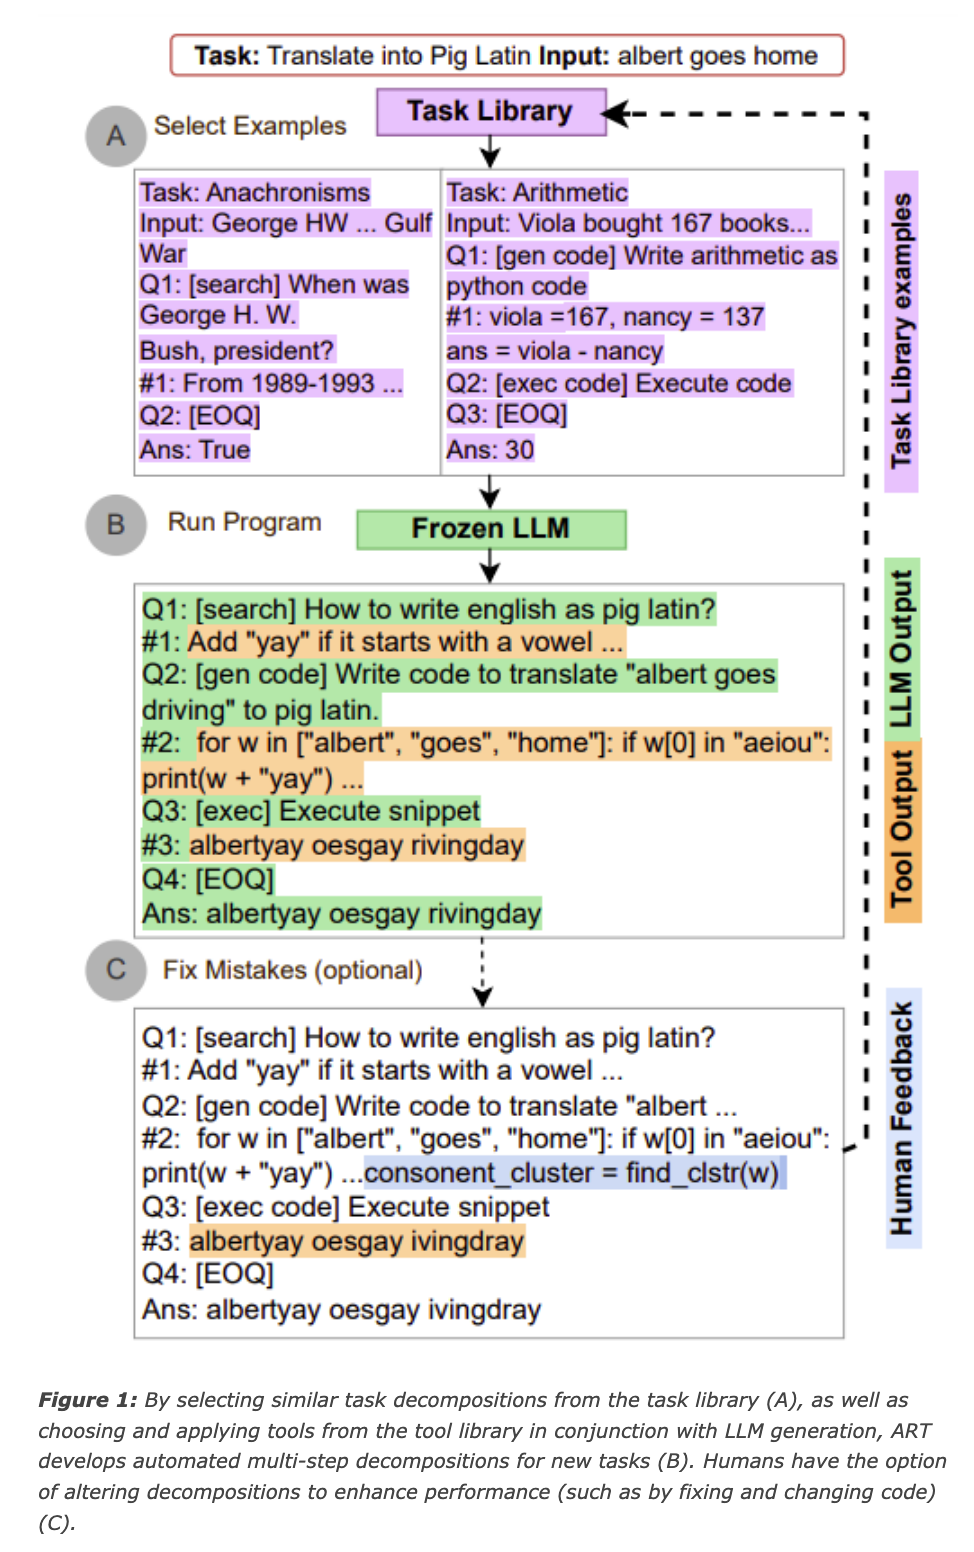

The example code for ART is present in a public repo and can be cloned by running the following commmand 

``` git clone https://github.com/bhargaviparanjape/language-programmes.git ```

Also at this point you can change the instance from ml.t3.medium to ml.g4dn.xlarge (ensure to stop and delete the model end-point: run the last cell in the notebook to do so)

In [ ]:
%conda install pip

In [15]:
%pip install -r ../language-programmes/requirements.txt

ERROR: Invalid requirement: '_libgcc_mutex=0.1=main' (from line 4 of ../language-programmes/requirements.txt)
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Run Few-shot (Direct) prompting:
%run  ../language-programmes/src/affordance/tasks/snarks.py \
--model_name text-davinci-002 \
--inference_strategy few_shot

ModuleNotFoundError: No module named 'datasets'

### 7. Clean up the endpoint

In [18]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()

NameError: name 'model_predictor' is not defined